# Linear Regression Unplugged: Neural Networks from Scratch Part 2

## Dataset generation

In [1]:
# YOU CAN SKIP THIS BLOCK

import numpy as np

RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

def generate_dataset(N: int, M: int, noise_scale: float = 1e-3, binary: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    # Generate features from the standard normal distribution
    X = np.random.normal(size=(N,M))
    # Generate coefficients from a uniform distrimution
    coeff = np.random.uniform(low=-1.0, high=1.0, size=(M,1))
    # Random intercept drawn from the range [-5, 5] uniformly
    intercept = np.random.uniform() * 10 - 5
    # Add some normally distributed noise with low standard deviation -> make the model's job harder
    noise = np.random.normal(scale=noise_scale, size=(N,1))
    # Calculate the target using a linear combination of the features
    y = X @ coeff + intercept + noise
    # Parse the target values to 0s and 1s in case of binary classification (instead of regression)
    if binary:
        # Sigmoid function -> push every value between 0 and 1
        y = 1.0 / (1.0 + np.exp(-y))
        # Round them to 0 or 1
        y = np.round(y)
    return X, y, coeff, intercept

In [2]:
N = 10 # Number of examples
M = 1 # Number of features
X, y, coeff, intercept = generate_dataset(N,M, noise_scale=2e-1)

## Plotting setup

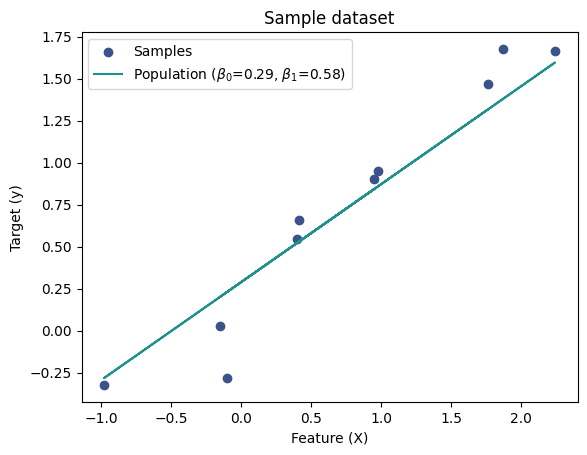

In [3]:
# YOU CAN SKIP THIS BLOCK

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import Colormap

# Colormap
cmap = plt.get_cmap("viridis", 5)

# Calculate the regression line
def linear_reg(x: np.ndarray, coeff: np.ndarray, intercept: float) -> np.ndarray:
    assert x.shape[-1] == coeff.shape[0]
    return x @ coeff + intercept

# Plot the data samples and the population distribution
def plot_dataset(cmap: Colormap, title: str = "Sample dataset") -> tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel("Feature (X)")
    ax.set_ylabel("Target (y)")
    ax.scatter(X, y[:,0], color=cmap(1), label="Samples")
    ax.plot(X, linear_reg(X, coeff, intercept), color=cmap(2), label=f"Population ($\\beta_0$={intercept:.2f}, $\\beta_1$={coeff[0,0]:.2f})")
    ax.legend()
    return fig, ax

fig, _ = plot_dataset(cmap) 

## Step 1: Bypassing Pytorch Modules

In [13]:
import torch
from torch import nn

torch.manual_seed(RANDOM_SEED)

X_tensor = torch.from_numpy(X.astype(np.float32))
y_tensor = torch.from_numpy(y.astype(np.float32))

In [14]:
class Perceptron:
    def __init__(self):    
        self.weight = torch.FloatTensor([[1.0]]).requires_grad_()
        self.bias = torch.FloatTensor([[0.0]]).requires_grad_()

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight + self.bias

    def parameters(self) -> list[torch.Tensor]:
        return [self.weight, self.bias]

In [15]:
perceptron1 = Perceptron()
# Number of iterations (in our case it matches the number of parameter updates)
EPOCHS = 20
# A Pytorch optimizer that takes care of Gradient Descent
# it updates the model's parameters (weight and bias) with a Learning Rate of 0.1
optimizer = torch.optim.SGD(perceptron1.parameters(), lr=0.1)

# Training loop
for i in range(EPOCHS):
    # Zero all the parameter gradients at the start of each epoch
    # otherwise they would be accumulating over the epochs
    optimizer.zero_grad()

    # Forward pass
    y_hat = perceptron1(X_tensor)

    # Loss calculation
    loss = nn.functional.mse_loss(y_hat, y_tensor)

    # Backward pass
    loss.backward()
    
    # Parameter update
    optimizer.step()

In [16]:
perceptron1.weight.item(), perceptron1.bias.item()

(0.7426644563674927, 0.1639004498720169)

## Step 2: Bypassing Pytorch optimizers

In [19]:
from typing import Iterable


class GradientDescent:
    def __init__(self, parameters: Iterable[torch.Tensor], lr: float):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self) -> None:
        for p in self.parameters:
            p.grad = None
    
    def step(self) -> None:
        for p in self.parameters:
            assert p.grad
            p.data -= self.lr * p.grad

In [20]:
perceptron2 = Perceptron()
# Number of iterations (in our case it matches the number of parameter updates)
EPOCHS = 20
# Our optimizer that takes care of Gradient Descent
# it updates the model's parameters (weight and bias) with a Learning Rate of 0.1
optimizer = GradientDescent(perceptron2.parameters(), lr=0.1)

# Training loop
for i in range(EPOCHS):
    # Zero all the parameter gradients at the start of each epoch
    # otherwise they would be accumulating over the epochs
    optimizer.zero_grad()

    # Forward pass
    y_hat = perceptron2(X_tensor)

    # Loss calculation
    loss = nn.functional.mse_loss(y_hat, y_tensor)

    # Backward pass
    loss.backward()
    
    # Parameter update
    optimizer.step()

In [24]:
assert (
    torch.allclose(perceptron1.weight, perceptron2.weight) 
    and 
    torch.allclose(perceptron1.bias, perceptron2.bias)
)
print("We are good!")

We are good!


## Step 3: Bypassing Pytorch's Autograd mechanism

![Gradient Computation Graph](../assets/linreg_gradcompgraph.png)

#### MSE Loss

\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{equation}

#### Derivative of MSE Loss

\begin{equation}
\frac{\partial \text{MSE}}{\partial \hat{y}_i} = \frac{2}{n} (\hat{y}_i - y_i)
\end{equation}


In [26]:
class Tensor:
    def __init__(self, data: np.ndarray):
        self.data = data.astype(np.float32)
        self.grad = np.zeros_like(data, dtype=np.float32)

    def item(self) -> float:
        return self.data.item()

    def __matmul__(self, other: "Tensor") -> "Tensor":
        return Tensor(self.data @ other.data)

    def __add__(self, other: "Tensor") -> "Tensor":
        return Tensor(self.data + other.data)

    def __sub__(self, other: "Tensor") -> "Tensor":
        return Tensor(self.data - other.data)

In [27]:
class Perceptron:
    def __init__(self):    
        self.weight = Tensor(np.array([[1.0]]))
        self.bias = Tensor(np.array([[0.0]]))

    def parameters(self):
        return [self.weight, self.bias]

    def __call__(self, x: Tensor) -> Tensor:
        return self.forward(x)

    def forward(self, x: Tensor) -> Tensor:
        self.x = x
        return x @ self.weight + self.bias
    
    def backward(self, out: Tensor) -> None:
        assert self.x
        self.weight.grad += self.x.data[:,0] @ out.grad
        self.bias.grad += out.grad.sum()

class MSELoss:
    def __call__(self, y_hat: Tensor, y: Tensor) -> Tensor:
        return self.forward(y_hat, y)

    def forward(self, y_hat: Tensor, y: Tensor) -> Tensor:
        self.y_hat = y_hat
        self.y = y
        return Tensor(((y.data - y_hat.data)**2).mean())
    
    def backward(self) -> None:
        assert self.y_hat and self.y
        self.y_hat.grad += -2/self.y.data.shape[0] * (self.y.data - self.y_hat.data)

class GradientDescent:
    def __init__(self, parameters: Iterable[Tensor], lr: float):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self) -> None:
        for p in self.parameters:
            p.grad = np.zeros_like(p.grad)
    
    def step(self) -> None:
        for p in self.parameters:
            p.data -= self.lr * p.grad

In [28]:
perceptron3 = Perceptron()
X_tensor, y_tensor = Tensor(X), Tensor(y)
# Number of iterations (in our case it matches the number of parameter updates)
EPOCHS = 20
# Our optimizer that takes care of Gradient Descent
# it updates the model's parameters (weight and bias) with a Learning Rate of 0.1
optimizer = GradientDescent(perceptron3.parameters(), lr=0.1)
# Our loss function as a class instance
loss_fn = MSELoss()

# Training loop
for i in range(EPOCHS):
    # Zero all the parameter gradients at the start of each epoch
    # otherwise they would be accumulating over the epochs
    optimizer.zero_grad()

    # Forward pass
    y_hat = perceptron3(X_tensor)

    # Loss calculation
    loss = loss_fn(y_hat, y_tensor)

    # Backward pass
    loss_fn.backward()
    perceptron3.backward(y_hat)
    
    # Parameter update
    optimizer.step()

In [31]:
assert (
    np.allclose(perceptron1.weight.detach().numpy(), perceptron3.weight.data)
    and 
    np.allclose(perceptron1.bias.detach().numpy(), perceptron3.bias.data)
)
print("We are good!")

We are good!
